In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines.datasets import load_waltons
from lifelines import *
from lifelines.utils import median_survival_times

In [2]:
df_test = load_waltons()
#df = pd.read_csv('data//data0326.csv',encoding = 'utf-8')

In [3]:
df_test.head()

,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137


In [4]:
df_test.groupby('group').T.count()

group
control    129
miR-137     34
Name: T, dtype: int64

In [5]:
# T表示时间间隔，E表示观测用户是否“死亡”
T = df_test['T']
E = df_test['E']

In [6]:
# Kaplan Meier model
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 163 total observations, 7 right-censored observations>

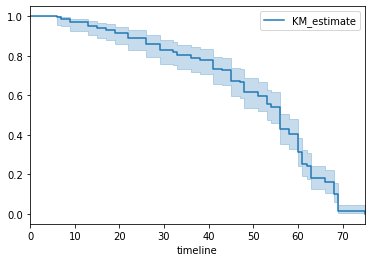

In [7]:
kmf.survival_function_
kmf.cumulative_density_
kmf.plot_survival_function() # or just kmf.plot()

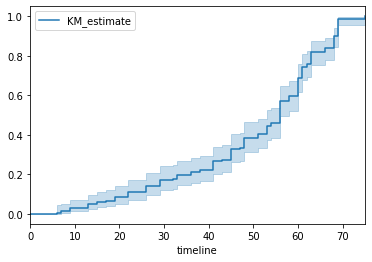

In [8]:
# 累计密度函数
kmf.plot_cumulative_density()

In [10]:
# # 指定时间关键字，改变模型索引方式
# kmf.fit(T, E, timeline=range(0, 100, 2))
# kmf.survival_function_   # index is now the same as range(0, 100, 2)
# kmf.confidence_interval_ # index is now the same as range(0, 100, 2)

In [11]:
# 中位生存时间
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

In [16]:
print(median_)
print(median_confidence_interval_)

56.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                    54.0                    58.0


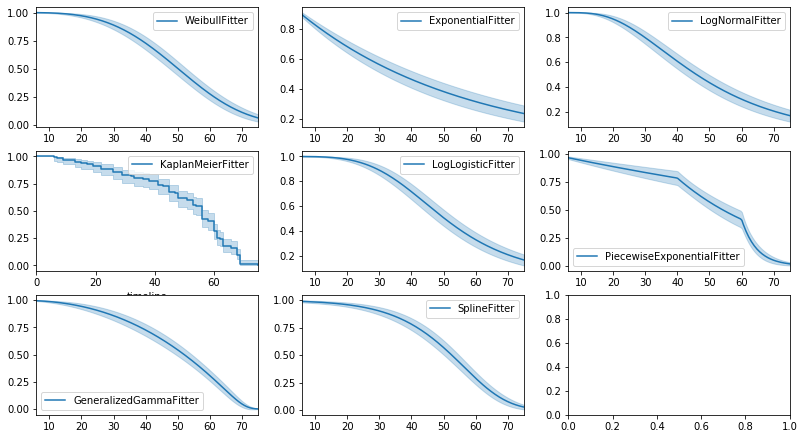

In [17]:
# 生存分析中的参数模型，eibull, Log-Normal, Log-Logistic
fig, axes = plt.subplots(3, 3, figsize=(13.5, 7.5))

kmf = KaplanMeierFitter().fit(T, E, label='KaplanMeierFitter')
wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter')
llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
pwf = PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter')
ggf = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
sf = SplineFitter(np.percentile(T.loc[E.astype(bool)], [0, 50, 100])).fit(T, E, label='SplineFitter')

wbf.plot_survival_function(ax=axes[0][0])
exf.plot_survival_function(ax=axes[0][1])
lnf.plot_survival_function(ax=axes[0][2])
kmf.plot_survival_function(ax=axes[1][0])
llf.plot_survival_function(ax=axes[1][1])
pwf.plot_survival_function(ax=axes[1][2])
ggf.plot_survival_function(ax=axes[2][0])
sf.plot_survival_function(ax=axes[2][1])

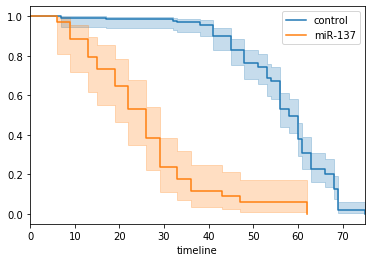

In [19]:
# 多分组，控制组与对照组
groups = df_test['group']
ix = (groups == 'miR-137')

kmf.fit(T[~ix], E[~ix], label='control')
ax = kmf.plot()

kmf.fit(T[ix], E[ix], label='miR-137')
ax = kmf.plot(ax=ax)

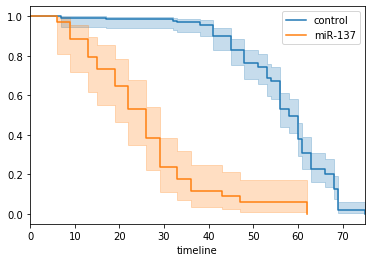

In [21]:
# 更多分组下的绘图
ax = plt.subplot(111)
kmf = KaplanMeierFitter()
for name, grouped_df in df_test.groupby('group'):
    kmf.fit(grouped_df["T"], grouped_df["E"], label=name)
    kmf.plot(ax=ax)

In [25]:
# # 右删失数据
# from lifelines.utils import datetimes_to_durations
# # start_times is a vector or list of datetime objects or datetime strings
# # end_times is a vector or list of (possibly missing) datetime objects or datetime strings
# T, E = datetimes_to_durations(start_times, end_times, freq='h')

In [23]:
# 生存表查看，
from lifelines.utils import survival_table_from_events
table = survival_table_from_events(T, E)
print(table.head())

          removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0       163      163
6.0             1         1         0         0      163
7.0             2         1         1         0      162
9.0             3         3         0         0      160
13.0            3         3         0         0      157


In [26]:
# K-M模型提供了整体的“平均”视图，对于各个级别的特定数据，需要使用生存回归
from lifelines.datasets import load_regression_dataset
regression_dataset = load_regression_dataset()
regression_dataset.head()

,var1,var2,var3,T,E
0,0.595170,1.143472,1.571079,14.785652,1
1,0.209325,0.184677,0.356980,7.335846,1
2,0.693919,0.071893,0.557960,5.269797,1
3,0.443804,1.364646,0.374221,11.684092,1
4,1.613324,0.125566,1.921325,7.639492,1


In [27]:
# Cox proportional hazard model
from lifelines import CoxPHFitter
# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(regression_dataset, 'T', event_col='E')
cph.print_summary()

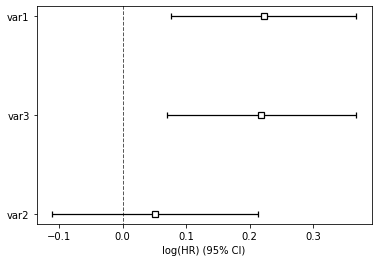

In [28]:
cph.plot()

In [29]:
# with a Weibull accelerated failure time model
# 比例参数lambda建模
from lifelines import WeibullAFTFitter

wft = WeibullAFTFitter()
wft.fit(regression_dataset, 'T', event_col='E')
wft.print_summary()

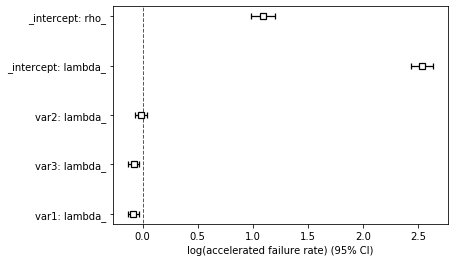

In [30]:
wft.plot()

In [31]:
# Using Aalen's Additive model，随时间变化
from lifelines import AalenAdditiveFitter
aaf = AalenAdditiveFitter(fit_intercept=False)
aaf.fit(regression_dataset, 'T', event_col='E')

<lifelines.AalenAdditiveFitter: fitted with 200 total observations, 11 right-censored observations>

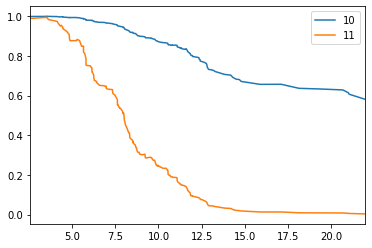

In [32]:
# CoxPHFitter和WeibullAFTFitter模型可以使用plot, predict_cumulative_hazards, and predict_survival_function
# predict_cumulative_hazards和predict_survival_function需要单独附加协变量
X = regression_dataset.drop(['E', 'T'], axis=1)
aaf.predict_survival_function(X.iloc[10:12]).plot()  # get the unique survival functions of two subjects

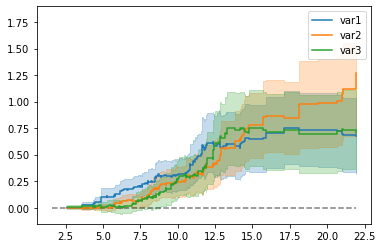

In [33]:
aaf.plot()

### 生存回归模型

#### Cox’s proportional hazard model

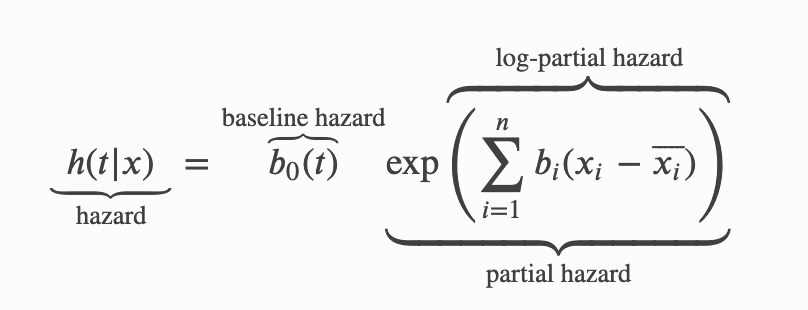

In [36]:
# Cox’s proportional hazard model，个人的对数风险是其静态协变量和随时间变化的总体水平基线风险的线性函数。
# b0(t)为基线危害，partial hazard为标量因子，仅会增加或减少基线危害

In [37]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

rossi_dataset = load_rossi()

cph = CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest')

cph.print_summary()  # access the results using cph.summary

In [75]:
# 结果解读：coef系数为正代表风险增加，系数为负代表风险降低
# prio系数为0.09，表示每增加一单位prio，基线危害将增加至exp(0.09)=1.1，即增加约10%的危害，较高的风险意味着事故更容易发生
# exp(coef)为风险比率，随时间不断变化，可以解释特定时期的危险比的加权平均值，危险比主要取决于随访的持续时间
# Concordance为一致性指数，评估预测时间准确性的一致性指数，AUC损失函数的概括，0.5随机预测的预期结果，1.0完美一致性，0.0完美反一致性（将预测值与-1相乘得到1.0）
# 基于k-fold的生存预测，https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-selection-in-survival-regression


In [38]:
cph.params_ # 查看参数

fin    -0.379422
age    -0.057438
race    0.313900
wexp   -0.149796
mar    -0.433704
paro   -0.084871
prio    0.091497
dtype: float64

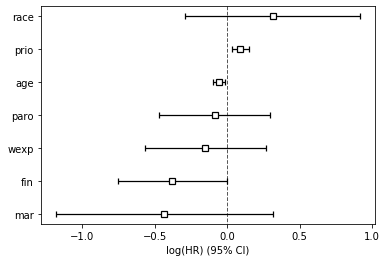

In [49]:
cph.plot() # 绘图

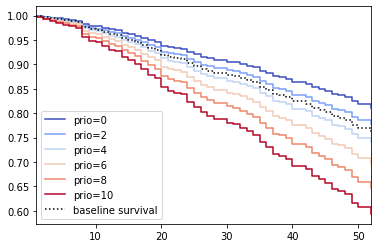

In [50]:
# fit后改变单变量值查看结果
cph.plot_covariate_groups('prio', [0, 2, 4, 6, 8, 10], cmap='coolwarm')

In [54]:
# # 衍生变量
# cph.plot_covariate_groups(
#     ['year', 'year**2'],
#     [
#         [0, 0],
#         [1, 1],
#         [2, 4],
#         [3, 9],
#         [8, 64],
#     ],
#     cmap='coolwarm')

In [56]:
# # 独热编码的分类变量
# cph.plot_covariate_groups(
#     ['d1', 'd2' 'd3', 'd4', 'd5'],
#     np.eye(5),
#     cmap='coolwarm')

In [57]:
# strata=['race']指定分层列，可以对于不遵循假设的分类变量较为有效，作为控制变量？
cph.fit(rossi_dataset, 'week', event_col='arrest', strata=['race'])
cph.print_summary()  # access the results using cph.summary

In [61]:
# 案例权重与采样权重
# 案例权重设置为2，表示有两个相同数据；采样权重需要设置`robust=True`获得更加准确的标准误差
df = pd.DataFrame({
    'T': [5, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'E': [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0],
    'weights': [1.1, 0.5, 2.0, 1.6, 1.2, 4.3, 1.4, 4.5, 3.0, 3.2, 0.4, 6.2],
    'month': [10, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'age': [4, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
})

cph = CoxPHFitter()
cph.fit(df, 'T', 'E', weights_col='weights', robust=True)
cph.print_summary()

//anaconda3/lib/python3.7/site-packages/lifelines/utils/__init__.py:1146: ConvergenceWarning: Column age has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:589: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 1.890. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  ConvergenceWarning,


In [62]:
# 不同集群的生存估计，id区分
df = pd.DataFrame({
    'T': [5, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'E': [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0],
    'month': [10, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'age': [4, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'id': [1, 1, 1, 1, 2, 3, 3, 4, 4, 5, 6, 7]
})

cph = CoxPHFitter()
cph.fit(df, 'T', 'E', cluster_col='id')
cph.print_summary()

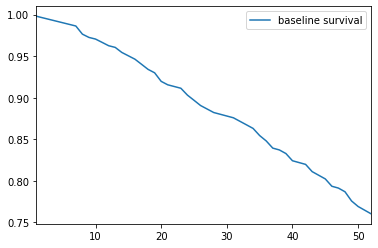

In [69]:
# 基准生存模型与基准风险
cph.fit(rossi_dataset, 'week', event_col='arrest')
cph.baseline_survival_.plot()
#cph.baseline_hazard_.plot()

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'age' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/lat

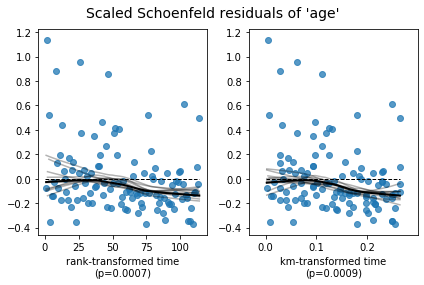

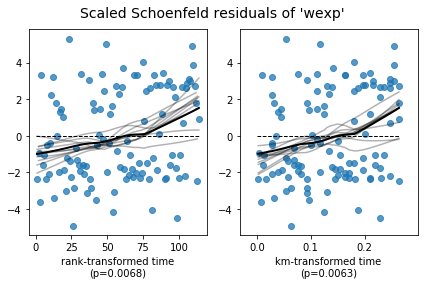

In [70]:
# 残差估计，官方进行中
# https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Cox%20residuals.html
# 变量残差检验
cph.check_assumptions(rossi, p_value_threshold=0.05, show_plots=True)

In [ ]:
# 可以用proportional_hazard_test进行检验
from lifelines.statistics import proportional_hazard_test
results = proportional_hazard_test(cph, rossi, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

In [40]:
print(rossi_dataset.week.max()) # 时间长度
print(cph.baseline_hazard_) # 查看基线危害，随时间变化

52
      baseline hazard
1.0          0.001958
2.0          0.001964
3.0          0.001965
4.0          0.001969
5.0          0.001975
6.0          0.001984
7.0          0.001995
8.0          0.009990
9.0          0.004053
10.0         0.002032
11.0         0.004103
12.0         0.004185
13.0         0.002097
14.0         0.006319
15.0         0.004267
16.0         0.004292
17.0         0.006460
18.0         0.006574
19.0         0.004432
20.0         0.011161
21.0         0.004513
22.0         0.002266
23.0         0.002279
24.0         0.009129
25.0         0.006902
26.0         0.007054
27.0         0.004732
28.0         0.004758
30.0         0.004806
31.0         0.002419
32.0         0.004862
33.0         0.004897
34.0         0.004966
35.0         0.010018
36.0         0.007608
37.0         0.010244
38.0         0.002596
39.0         0.005212
40.0         0.010474
42.0         0.005329
43.0         0.010696
44.0         0.005426
45.0         0.005467
46.0         0.011055
47.0   

In [43]:
print(cph.log_likelihood_) # 最大对数似然值
print(cph.variance_matrix_) # 系数方差矩阵

-658.7476594460855
[[ 3.66261056e-02 -2.58829360e-04 -3.74367463e-03  6.56176845e-05
   1.87736947e-03  2.66117273e-03 -2.02214723e-04]
 [-2.58829360e-04  4.83976696e-04 -3.03302535e-04 -1.43741382e-03
  -1.01841958e-03  4.73775724e-04 -1.93797212e-05]
 [-3.74367463e-03 -3.03302535e-04  9.48595504e-02  1.94156154e-03
   1.04219106e-02 -1.89358990e-03  5.05037027e-04]
 [ 6.56176845e-05 -1.43741382e-03  1.94156154e-03  4.50391520e-02
  -1.46416566e-02 -1.62320485e-03  1.70041109e-03]
 [ 1.87736947e-03 -1.01841958e-03  1.04219106e-02 -1.46416566e-02
   1.45823213e-01 -4.44928539e-03 -4.83913367e-04]
 [ 2.66117273e-03  4.73775724e-04 -1.89358990e-03 -1.62320485e-03
  -4.44928539e-03  3.83206746e-02  8.42770109e-04]
 [-2.02214723e-04 -1.93797212e-05  5.05037027e-04  1.70041109e-03
  -4.83913367e-04  8.42770109e-04  8.20739411e-04]]


In [44]:
# 惩罚项与稀疏回归，目的：稳定系数、估计值缩小到0，贝叶斯解释，创建稀疏系数
# COX模型包括L1和L2惩罚项

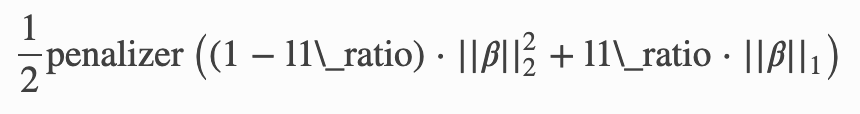

In [48]:
# cph = CoxPHFitter(penalizer=0.1, l1_ratio=1.0) # only sparse solutions，稀疏解决方案，报错
# cph.fit(rossi, 'week', 'arrest')
# cph.print_summary()